# Hasse Search Space Estimation

## Load Data

In [1]:
import json
import numpy as np
from os import listdir
from pprint import pprint
from statistics import mean, stdev
from typing import List, Dict

In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm
from tqdm import tqdm

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load data

def get_file_paths(dir_path: str = "results") -> List[str]:
    file_names = listdir(dir_path)
    file_names = [file_name for file_name in file_names if file_name.endswith(".json")]

    file_paths = [
        f"{dir_path}/{file_name}"  for file_name in file_names
    ]
    return file_paths


def load_data(file_path: str) -> Dict:
    with open(file_path, "r") as data_file:
        return json.load(data_file)

experiment_paths = get_file_paths()
experiments = [
    load_data(file_path) for file_path in experiment_paths
]

print(f"Experiment count: {len(experiments)}")
print(experiments[0])

Experiment count: 7
{'meta': {'start': '2025-11-18 18:26:18.657090', 'end': '2025-11-18 19:31:15.840446'}, 'config': {'gate_set': '[H, S, T, CX]', 'gate_count': 6, 'qubit_num': 4, 'sample_num': 1280000, 'seed_num': 30}, 'results': {'hasse_duplicate_counts': [205798, 205061, 204543, 205035, 205264, 205142, 204425, 204848, 205112, 204994, 204868, 204598, 205385, 204152, 204584, 204591, 204674, 204612, 204764, 204612, 204489, 204885, 204226, 205486, 204687, 204271, 204580, 205278, 205006, 204977], 'mean_hasse_duplicate_count': 204831.56666666668, 'hasse_encoding_times': [95.335962, 94.534925, 95.357927, 94.851802, 94.584984, 95.242662, 94.549186, 94.162962, 93.977189, 94.579485, 93.418728, 94.178735, 94.834662, 94.446752, 95.053528, 94.889693, 94.860658, 94.453488, 94.594282, 94.520092, 95.579958, 94.303948, 94.551686, 94.930246, 95.34561, 94.81371, 95.153108, 95.130927, 94.397361, 95.591486], 'mean_hasse_encoding_time': 94.74085806666666, 'list_duplicate_counts': [4336, 4218, 4156, 4233,

In [5]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

In [6]:
# Filter experiments

def filter_experiments(experiments: List[Dict], target_qubit_nums: List[int] = None, target_gate_counts: List[int] = None, sort_by: str = "qubit_num") -> List:
    assert target_qubit_nums is not None or target_gate_counts is not None

    filtered_experiments = []
    for experiment in experiments:

        if target_qubit_nums is None:
            if experiment["config"]["gate_count"] in target_gate_counts:
                filtered_experiments.append(experiment)
        elif target_gate_counts is None:
            if experiment["config"]["qubit_num"] in target_qubit_nums:
                filtered_experiments.append(experiment)
        elif experiment["config"]["gate_count"] in target_gate_counts and experiment["config"]["qubit_num"] in target_qubit_nums: 
            filtered_experiments.append(experiment)

    filtered_experiments.sort(key=lambda item: item["config"][sort_by])
    return filtered_experiments

## Compute Search Space Size

In [7]:
def calculate_list_search_space_size(qubit_num: int, gate_count: int) -> int:
    # assuming Clifford+T gate set 

    return (qubit_num * (qubit_num - 1) + 3 * qubit_num) ** gate_count

In [8]:
# Calculate search space size

def calculate_expected_duplicates(size: int, sample_num: int) -> int:
    expected_duplicates = sample_num - size + size * (1 - 1/size) ** sample_num
    return expected_duplicates


def estimate_search_space_size(sample_num: int, actual_duplicates: int, lower_bound: int, upper_bound: int) -> int:
    if actual_duplicates == 0:
        return upper_bound

    # Expected number of duplicates decreases monotonically as search space increases

    search_range = (lower_bound, upper_bound)
    search_post_count = 3

    while True:

        # cut search interval into bins and evaluate
        search_posts = [
            i * (search_range[1] - search_range[0]) / (search_post_count - 1) + search_range[0] for i in range(search_post_count)
        ]
        search_posts = [int(search_post) for search_post in search_posts]

        smallest_delta = np.inf
        best_i = -1

        for search_post_i, search_post in enumerate(search_posts):
            estimated_duplicates = calculate_expected_duplicates(
                search_post, sample_num)
            delta = abs(estimated_duplicates - actual_duplicates)

            if delta < smallest_delta:
                smallest_delta = delta
                best_i = search_post_i

        if smallest_delta <= 1:
            return search_posts[best_i]

        try:
            if calculate_expected_duplicates(search_posts[best_i], sample_num) > actual_duplicates:
                search_range = (search_posts[best_i], search_posts[best_i + 1])
            else:
                search_range = (search_posts[best_i - 1], search_posts[best_i])
        except IndexError:  # Case: border of search posts is closest to solution.
            return search_posts[best_i]

        if (search_range[1] - search_range[0]) / (search_post_count - 1) <= 1:
            return search_posts[best_i]

In [9]:
for experiment in experiments:
    print("")
    print(experiment["config"])
    print(experiment["results"]["list_duplicate_counts"])

    actual_value = calculate_list_search_space_size(
        experiment["config"]["qubit_num"], experiment["config"]["gate_count"])

    estimates = [
        estimate_search_space_size(
            experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual_value * 5)
            for duplicate_count in experiment["results"]["list_duplicate_counts"]
    ]
    
    mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_list_duplicate_count"], lower_bound=1, upper_bound=actual_value * 5)

    print(f"Estimates: {estimates}")
    print(f"Mean estimate: {mean_estimate}")
    print(f"Actual: {actual_value}")



{'gate_set': '[H, S, T, CX]', 'gate_count': 6, 'qubit_num': 4, 'sample_num': 1280000, 'seed_num': 30}
[4336, 4218, 4156, 4233, 4333, 4345, 4239, 4179, 4304, 4274, 4376, 4285, 4345, 4229, 4244, 4216, 4313, 4354, 4356, 4383, 4279, 4265, 4249, 4271, 4284, 4300, 4290, 4315, 4227, 4300]
Estimates: [188490240, 193797360, 196655040, 193097520, 188606880, 188140320, 192805920, 195605280, 189889920, 191231280, 186740640, 190764720, 188140320, 193272480, 192572640, 193855680, 189540000, 187732080, 187673760, 186507360, 191056320, 191639520, 192339360, 191406240, 190823040, 190123200, 190531440, 189423360, 193389120, 190123200]
Mean estimate: 190823040
Actual: 191102976

{'gate_set': '[H, S, T, CX]', 'gate_count': 6, 'qubit_num': 3, 'sample_num': 320000, 'seed_num': 30}
[4535, 4339, 4432, 4375, 4452, 4419, 4551, 4394, 4497, 4399, 4544, 4485, 4333, 4444, 4487, 4558, 4434, 4451, 4510, 4400, 4452, 4425, 4462, 4478, 4487, 4512, 4447, 4444, 4438, 4456]
Estimates: [11182751, 11693743, 11443461, 115964

## List Experiment Details

In [10]:
gate_counts = [
    experiment["config"]["gate_count"] for experiment in experiments
]
gate_counts = list(set(gate_counts))
gate_counts.sort()

qubit_nums = [
    experiment["config"]["qubit_num"] for experiment in experiments
]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

In [11]:

for qubit_num in qubit_nums:
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[qubit_num], sort_by="gate_count")

    for experiment in filtered_experiments:
        printb(f"\nExperiment with {experiment['config']['qubit_num']} qubits and {experiment['config']['gate_count']} gates:")
        print(f"List search space size: ", calculate_list_search_space_size(
            experiment['config']['qubit_num'],
            experiment['config']['gate_count']
        ))
        print(f"Sample size: {experiment['config']['sample_num']}")



Experiment with 3 qubits and 4 gates:
List search space size:  50625
Sample size: 20000

Experiment with 3 qubits and 6 gates:
List search space size:  11390625
Sample size: 320000

Experiment with 3 qubits and 8 gates:
List search space size:  2562890625
Sample size: 2560000

Experiment with 4 qubits and 4 gates:
List search space size:  331776
Sample size: 40000

Experiment with 4 qubits and 6 gates:
List search space size:  191102976
Sample size: 1280000

Experiment with 5 qubits and 4 gates:
List search space size:  1500625
Sample size: 80000

Experiment with 6 qubits and 4 gates:
List search space size:  5308416
Sample size: 160000


## Search Space Hasse vs. List

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 1018.53it/s]


Search space sizes for 4 gates.
Qubit nums:  [3, 4, 5, 6]
List search space:  [50625, 331776, 1500625, 5308416]
Hasse search space:  [10059, 44977, 162767, 499608]
Ratio:  [0.1987, 0.1356, 0.1085, 0.0941]


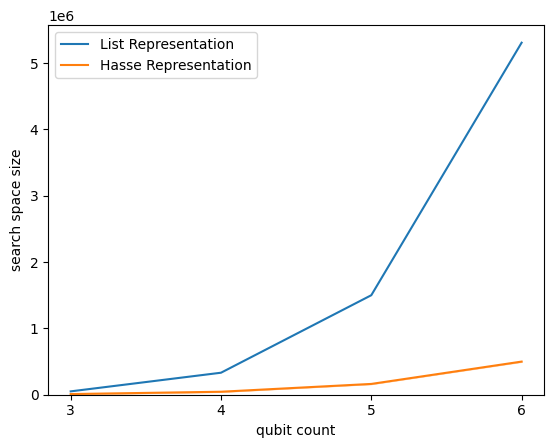

100%|██████████| 2/2 [00:00<00:00, 1027.76it/s]


Search space sizes for 6 gates.
Qubit nums:  [3, 4]
List search space:  [11390625, 191102976]
Hasse search space:  [404899, 3560230]
Ratio:  [0.0355, 0.0186]


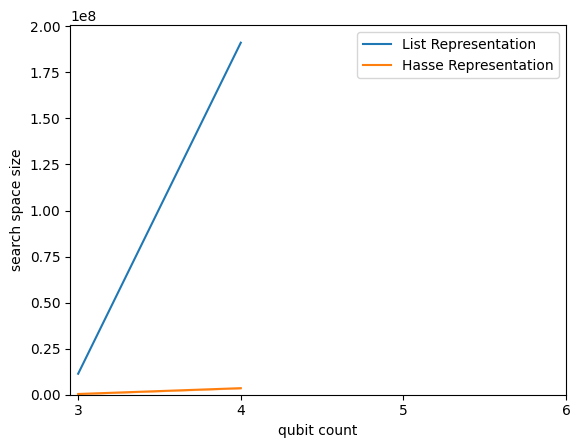

100%|██████████| 1/1 [00:00<00:00, 839.70it/s]


Search space sizes for 8 gates.
Qubit nums:  [3]
List search space:  [2562890625]
Hasse search space:  [12000075]
Ratio:  [0.0047]


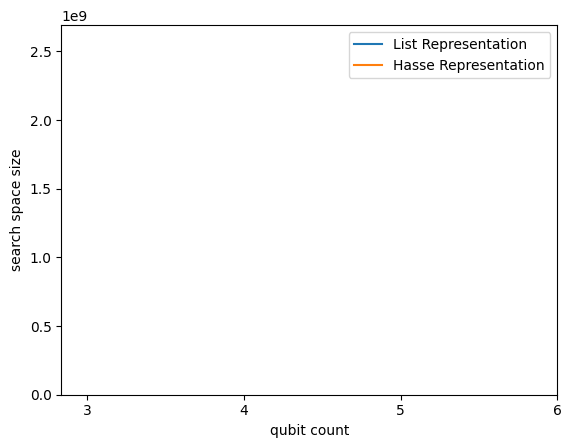

In [12]:
# accross gate counts

for gate_count in gate_counts:

    # if gate_count > 10:
    #     break

    filtered_experiments = filter_experiments(
        experiments, target_gate_counts=[gate_count])

    encountered_qubit_nums = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in tqdm(filtered_experiments):
        encountered_qubit_nums.append(experiment["config"]["qubit_num"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=3 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=3 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {gate_count} gates.")
    print("Qubit nums: ", encountered_qubit_nums)
    print("List search space: ", total_list_values)
    print("Hasse search space: ", total_hasse_estimates)
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_qubit_nums, total_list_values,
            label="List Representation")

    ax.plot(encountered_qubit_nums, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("qubit count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(qubit_nums)

    plt.legend()
    plt.savefig(f"results/fig_space_{gate_count}g_varying_q.png", bbox_inches='tight')
    plt.show()


Search space sizes for 3 qubits.
Gate counts:  [4, 6, 8]
List search space:  [50625, 11390625, 2562890625]
Hasse search space:  [10059, 404903, 12000075]
Ratio:  [0.1987, 0.0355, 0.0047]


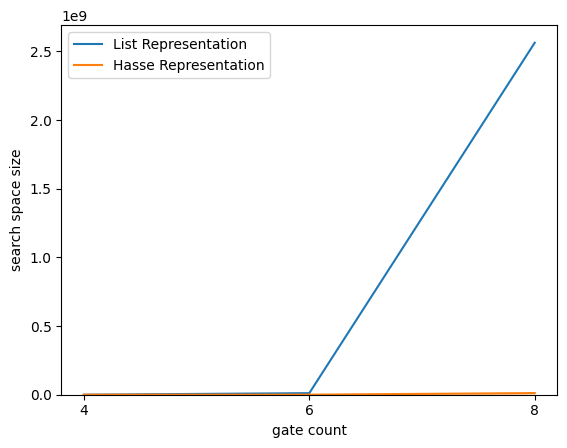


Search space sizes for 4 qubits.
Gate counts:  [4, 6]
List search space:  [331776, 191102976]
Hasse search space:  [44980, 3560253]
Ratio:  [0.1356, 0.0186]


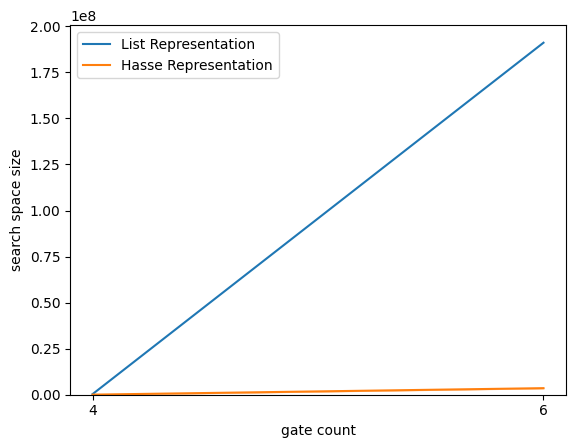


Search space sizes for 5 qubits.
Gate counts:  [4]
List search space:  [1500625]
Hasse search space:  [162779]
Ratio:  [0.1085]


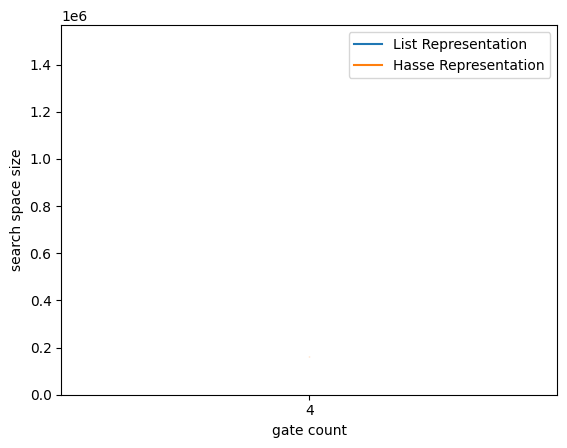


Search space sizes for 6 qubits.
Gate counts:  [4]
List search space:  [5308416]
Hasse search space:  [499608]
Ratio:  [0.0941]


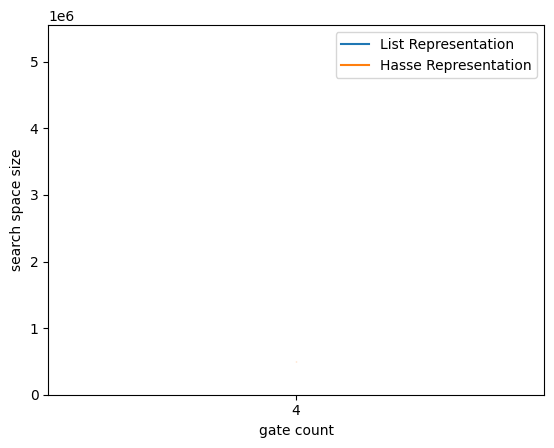

In [13]:
# accross qubit nums

for qubit_num in qubit_nums:

    # filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
    #                                           qubit_num], target_gate_counts=[5, 10], sort_by="gate_count")
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
                                              qubit_num], sort_by="gate_count")

    encountered_gate_counts = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in filtered_experiments:
        encountered_gate_counts.append(experiment["config"]["gate_count"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=2 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=2 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {qubit_num} qubits.")
    print("Gate counts: ", encountered_gate_counts)
    print("List search space: ", total_list_values)
    print("Hasse search space: ", total_hasse_estimates)
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_gate_counts, total_list_values,
            label="List Representation")

    ax.plot(encountered_gate_counts, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_gate_counts, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("gate count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(encountered_gate_counts)

    plt.legend()

    plt.savefig(
        f"results/fig_space_{qubit_num}q_varying_g.png", bbox_inches='tight')
    plt.show()